# All Sell-out

Goal: 
1. Process PFG data (source = mealticket.com)
2. Analyze data using COVID segmentation
3. Compare sell-out (PFG) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import pyodbc

from distributor_transformation import transform_pfg, set_dictionary, set_time
from sellout_model import process_list, analyze, add_time
from sellout_teradata import teradata_sales
from sellout_import import import_pfg, all_df, import_all
from sellout_azure import azure_sellin

# Import All

In [2]:
df = import_all('region')

C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_region_bek.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_region_pfg.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_region_sysco_ca.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_region_us_foods.zip


In [4]:
df.to_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\North America\SELLOUT_REGION.csv', index=False)

In [5]:
df = import_all('sellout_sellin')

C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_sellin_bek.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_sellin_pfg.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_sellin_sysco_ca.zip
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_sellin_us_foods.zip


In [6]:
df.to_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\North America\SELLOUT_AND_SELLIN.csv', index=False)

In [15]:
df.columns

Index(['city', 'state name', 'covid segmentation - l1',
       'covid segmentation - l2', 'restaurant service type',
       'consolidated category', 'calendar week year', 'distributor', 'lbs',
       'sma_4', 'sma_8', 'sma_12', 'yoy week', 'lbs_ly', 'sma_4_ly',
       'sma_8_ly', 'sma_12_ly', 'baseline week', 'lbs_baseline',
       'sma_4_baseline', 'sma_8_baseline', 'sma_12_baseline', 'lbs_lag_1',
       'lbs_lag_2', 'lbs_lag_3', 'lbs_lag_4', 'lbs_baseline_lag_1',
       'lbs_ly_lag_1', 'sma_4_lag_1', 'sma_4_ly_lag_1', 'sma_4_baseline_lag_1',
       'lbs_precovid', 'week starting (sun)', 'week ending (sat)',
       'covid week', 'region'],
      dtype='object')

In [3]:
df.groupby(['distributor'])['week ending (sat)'].agg(['min','max'])

,min,max
distributor,,
Ben E Keith,2019-01-12,2024-04-20
PFG,2019-01-05,2024-04-20
Sysco CA,2019-01-05,2024-04-20
US Foods,2019-01-05,2024-01-20


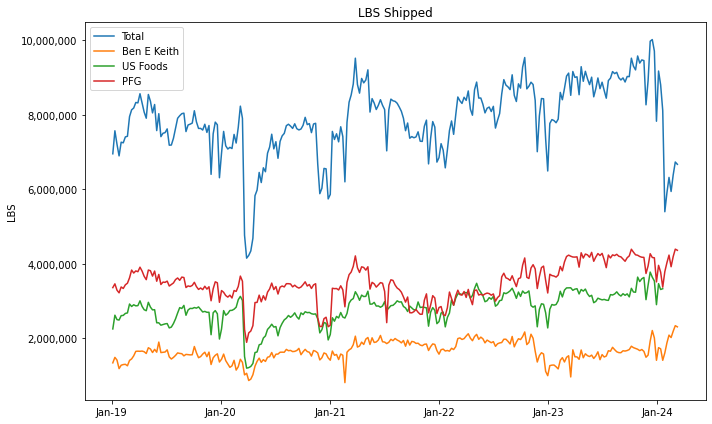

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

graph_data = df[~df['distributor'].isin(['Sysco CA'])].groupby(['week ending (sat)','distributor'])['lbs'].sum().reset_index()
graph_data.loc[:, 'week ending (sat)'] = pd.to_datetime(graph_data['week ending (sat)'])

ax.plot('week ending (sat)','lbs', data=graph_data.groupby(['week ending (sat)']).sum().reset_index())
ax.plot('week ending (sat)','lbs', data=graph_data[graph_data['distributor']=='Ben E Keith'])
ax.plot('week ending (sat)','lbs', data=graph_data[graph_data['distributor']=='US Foods'])
ax.plot('week ending (sat)','lbs', data=graph_data[graph_data['distributor']=='PFG'])

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Total','Ben E Keith', 'US Foods', 'PFG'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))

ax.set_ylabel('LBS')

ax.set_title(f'LBS Shipped')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

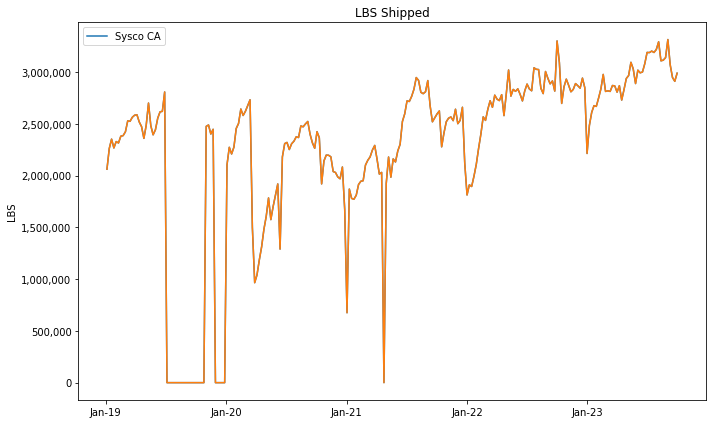

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

graph_data = df[df['distributor'].isin(['Sysco CA'])].groupby(['week ending (sat)','distributor'])['lbs'].sum().reset_index()
graph_data.loc[:, 'week ending (sat)'] = pd.to_datetime(graph_data['week ending (sat)'])

ax.plot('week ending (sat)','lbs', data=graph_data.groupby(['week ending (sat)']).sum().reset_index())
ax.plot('week ending (sat)','lbs', data=graph_data[graph_data['distributor']=='Sysco CA'])

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Sysco CA'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))

ax.set_ylabel('LBS')

ax.set_title(f'LBS Shipped')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

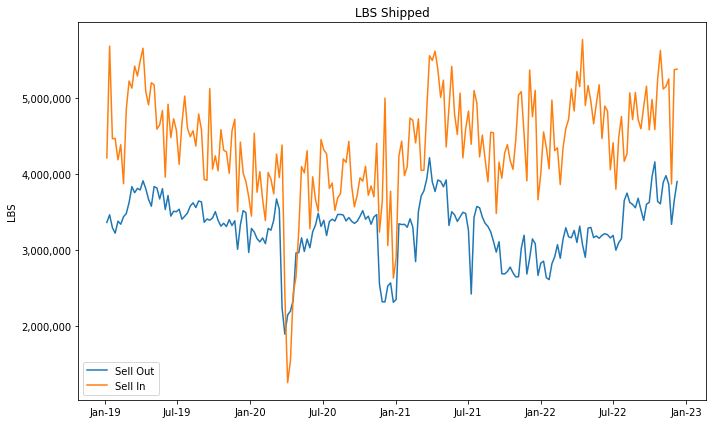

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

fig, ax = plt.subplots()

distributors = ['PFG']

graph_data = df[df['distributor'].isin(distributors)].groupby(['week ending (sat)','distributor'])[['lbs','mccain lbs']].sum().reset_index()
graph_data.loc[:, 'week ending (sat)'] = pd.to_datetime(graph_data['week ending (sat)'])

#ax.plot('week ending (sat)','lbs', data=graph_data.groupby(['week ending (sat)']).sum().reset_index())
ax.plot('week ending (sat)','lbs', data=graph_data)
ax.plot('week ending (sat)','mccain lbs', data=graph_data)

#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
ax.legend(['Sell Out','Sell In'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

ax.set_ylabel('LBS')

ax.set_title(f'LBS Shipped')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

### Thanksgiving 2022 vs 2021

  Week Ending F23  F23 Percent Change  F22 Percent Change
0      2022-10-29            0.003905           -0.015314
1      2022-11-05            0.043706           -0.004058
2      2022-11-12           -0.007822            0.050449
3      2022-11-19           -0.046639            0.025480
4      2022-11-26           -0.168677           -0.152293


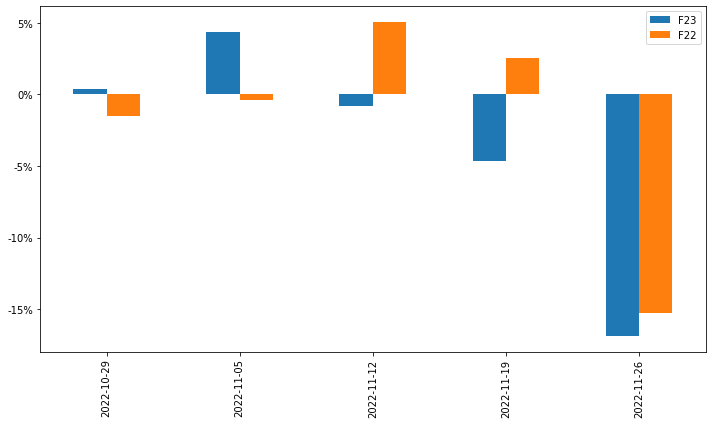

In [71]:
fig, ax = plt.subplots()

graph_data = df[~df['distributor'].isin(['Sysco CA'])].groupby(['week ending (sat)','distributor'])['lbs'].sum().reset_index()

df1 = graph_data[(graph_data['week ending (sat)']>'2021-07-01') & (graph_data['week ending (sat)']<='2021-11-27')]
df2 = graph_data[(graph_data['week ending (sat)']>'2022-07-01') & (graph_data['week ending (sat)']<='2022-11-27')]

df1_change = df1.groupby('week ending (sat)')['lbs'].sum().pct_change(periods=1)[-5:].reset_index()
df2_change = df2.groupby('week ending (sat)')['lbs'].sum().pct_change(periods=1)[-5:].reset_index()


df_change = pd.concat([df2_change, df1_change['lbs']], axis=1)

df_change.columns = ['Week Ending F23', 'F23 Percent Change', 'F22 Percent Change']

print(df_change)

#output1.groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=1)[-20:].plot(kind='bar', ax=ax)

df_change.plot(kind='bar', ax=ax)

x_ticks = df_change['Week Ending F23'].tolist()
x_range = np.arange(len(x_ticks))

plt.xticks(x_range, x_ticks)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))

#ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))

ax.legend(['F23', 'F22'])

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

### Covert State names to abbreviations

In [3]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

df['state_code'] = df['state name'].map(us_state_to_abbrev)

df['state_code'].isna().sum()
#abbrev_to_us_state

13946

202223.0


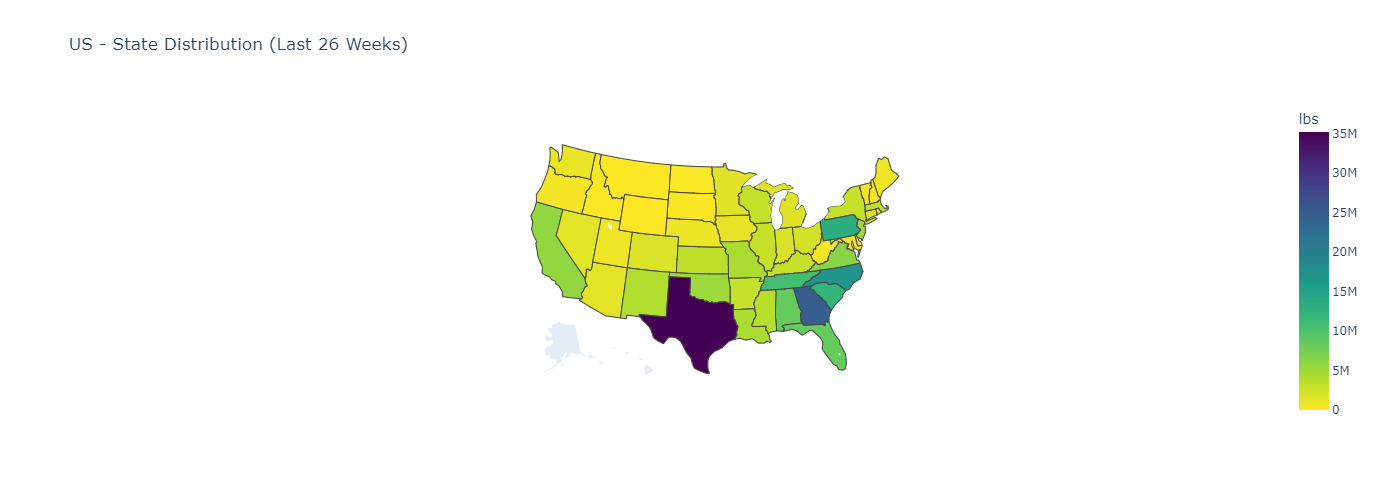

In [7]:
import plotly.express as px

#202223
#202248

cal = df['calendar week year'].iloc[-26:].min()

print(cal)

#graph_data = df[(df['distributor']=='PFG') & (df['calendar week year']>cal)].groupby('state_code')['lbs'].sum().reset_index()
graph_data = df[(df['calendar week year']>cal)].groupby('state_code')['lbs'].sum().reset_index()

fig = px.choropleth(graph_data,
                    locations='state_code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='lbs',
                    color_continuous_scale="Viridis_r", 
                    width=1000, height=500,
                    title="US - State Distribution (Last 26 Weeks)")

#fig.set_size_inches((10, 6))

fig.show()

In [ ]:
import pandas as pd 
import plotly.express as px

df = pd.read_csv(r'C:\Users\13525\Desktop\Insights Bees\plotly_express_choropleth\Data\state_market_tracker.tsv000.gz', sep='\t')
df=df[['period_begin','state','state_code','property_type','median_sale_price']]
df=df[ (df['property_type']=='Single Family Residential')] 
df.rename({'median_sale_price':'Median Sales Price ($)'},axis=1, inplace=True)
df['period_begin'] = pd.to_datetime(df['period_begin']).dt.date.astype(str)
df=df.sort_values("period_begin") # Make sure you sort the time horizon column in ascending order because this column is in random order in the raw dataset

fig = px.choropleth(df,
                    locations='state_code', 
                    locationmode="USA-states", 
                    color='Median Sales Price ($)',
                    color_continuous_scale="Viridis_r", 
                    scope="usa",
                    animation_frame='period_begin') #make sure 'period_begin' is string type and sorted in ascending order

fig.show()

In [11]:
graph_data['covid segmentation - l1'].value_counts()

Accommodation                                     1
Non-Defined Segment                               1
Travel/Transport                                  1
Schools & Education                               1
Region Chains                                     1
Recreation                                        1
QSR / Fast Casual                                 1
Public Sector (On site)                           1
Prisons / Corrections                             1
Other / Unknown                                   1
Independents (IOs) / Local Eateries / Takeaway    1
All Other Non-Commercial                          1
Hospitals & Healthcare Facilities                 1
Healthcare                                        1
Grocery - Convenience                             1
Elderly Care Homes                                1
Distributor / Other Accounts                      1
Casual Dining                                     1
Bars & Pubs                                       1
All Other Re

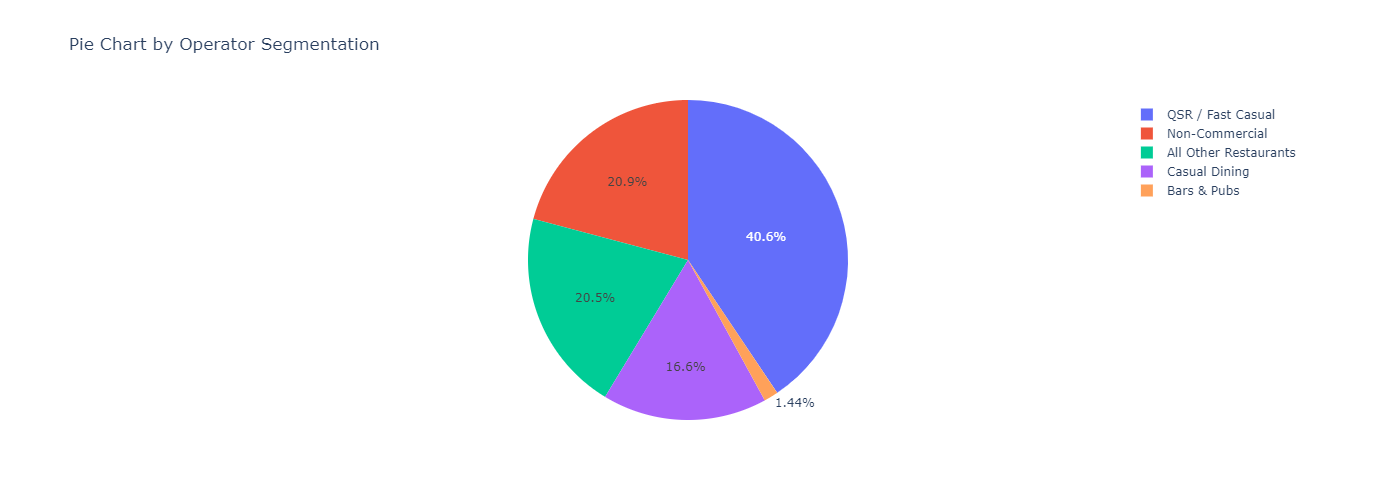

In [15]:
import plotly.express as px

graph_data = df[(df['calendar week year']>cal)].groupby('covid segmentation - l1')['lbs'].sum().reset_index()

graph_data.loc[~graph_data['covid segmentation - l1'].isin(['Casual Dining','Bars & Pubs','All Other Restaurants','QSR / Fast Casual']),'covid segmentation - l1'] = 'Non-Commercial'

fig = px.pie(graph_data, values='lbs', names='covid segmentation - l1',
             width=1000, height=500,
             title="Pie Chart by Operator Segmentation"
            )
fig.show()

### Sell-in vs. Sell-out


In [1]:
from sellout_import import import_pfg, all_df, import_all, import_bek, import_usfoods
from distributor_transformation import transform_bek, transform_usfoods, transform_pfg
import os
import pandas as pd

In [2]:
dimprod = pd.read_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Junk\dimproduct.csv')

## BEK

In [3]:
#file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
#file_name = 'BEK Update.xls'

file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\2021-12-17\Data Sources\\'
file_name = 'BEK Update.xls'

df = import_bek(file_path + file_name)

df_bek = transform_bek(df, 'BEK - US.xlsx')

Shape before adding dictionary: (167847, 22)
Shape after adding segmentation: (167847, 28)
Shape after adding product segmentation: (167847, 31)
Shape before adding time: (167847, 32)
Shape after adding time: (167847, 33)
Shape after adding dictionary: (167843, 34)
Nothing missing for COVID Segmentation - L1
Nothing missing for products


In [93]:
df_bek.columns

Index(['Branch', 'Business Unit', 'SIC Code', 'SIC Sub', 'Customer Nbr.',
       'Customer Name', 'Customer Address1', 'Customer Address2', 'City',
       'State', 'Customer Zip', 'Family', 'Brand', 'Group', 'SKU ID',
       'Prod Nbr', 'Product', 'Prod Nbr.1', 'Pack / Size',
       'Product Ext.Description', 'Week of', 'Month', 'LBS',
       'COVID Segmentation - L1', 'COVID Segmentation - L2',
       'COVID Segmentation - (Restaurants)',
       'COVID Segmentation - (Restaurants: Sub-Segment)',
       'Restaurant Service Type', 'Cuisine Type', 'Consolidated Category',
       'L1 Product Hierarchy', 'L2 Product Hierarchy', 'Week Starting',
       'Calendar Week Year', 'State Name'],
      dtype='object')

In [94]:
df_bek['SKU ID'].value_counts()

82910195      21639
82905631      21291
1000007275    14591
1000006416    10368
SON00543       8636
              ...  
MCS90             3
96110844          3
1000008676        3
1000007470        2
1000008470        2
Name: SKU ID, Length: 185, dtype: int64

In [4]:
df_bek_g = df_bek.groupby(['Calendar Week Year','Week Starting','SKU ID'])['LBS'].sum().reset_index()

In [5]:
df_bek_g.loc[:, 'Product Short Code'] = df_bek_g['SKU ID'].apply(lambda x: str(x).replace('.0',''))

df_bek_g2 = df_bek_g.merge(dimprod[['Product Short Code','Product Group Format','Product Sub Group Format']], how='left', on=['Product Short Code'])

df_bek_g2['Distributor'] = 'Ben E Keith'

df_bek_g2.head()

,Calendar Week Year,Week Starting,SKU ID,LBS,Product Short Code,Product Group Format,Product Sub Group Format,Distributor
0,202135,2021-08-29,1000000496,1830.0,1000000496,SPECIALTY,CUT,Ben E Keith
1,202135,2021-08-29,1000000516,48.0,1000000516,APPETIZERS,FORMED CHEESE,Ben E Keith
2,202135,2021-08-29,1000000904,157644.0,1000000904,DIFFERENTIATED FRIES,CLEAR COAT,Ben E Keith
3,202135,2021-08-29,1000001223,28860.0,1000001223,DIFFERENTIATED FRIES,BATTERED,Ben E Keith
4,202135,2021-08-29,1000001261,150.0,1000001261,LOCAL PORTFOLIO,BAKERY,Ben E Keith


## US Foods

In [6]:
#file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\2021-12-17\Data Sources\\'
file_name = 'US Foods Update.csv'



df = import_usfoods(file_path + file_name)

Importing csv file 2022-12-16 13:04:49.264755
Import file shape: (50265, 23)


In [7]:
df_usfoods = transform_usfoods(df, 'US Foods - US.xlsx')
df_usfoods.columns

Shape before adding dictionary: (50265, 23)
Total before dictionary: 39415614.73
Total after dictionary: 39415614.73
Shape after adding dictionary: (50265, 37)
Nothing missing for COVID Segmentation - L1
Nothing missing for products


Index(['Region', 'Area', 'Market', 'Pyramid Segment', 'Business Unit',
       'Merch Category', 'PIM Group', 'Manufacturer Item Number', 'PIM #',
       'ASYS #', 'Product Description', 'Pack Size', 'Vendor #', 'Vendor',
       'Brand', 'Brand Type', 'Attribute 1', 'Attribute 2', 'Attribute 3',
       'Attribute 4', 'Attribute 5', 'Calendar Week', 'LBS', 'PIM Group-lower',
       'COVID Segmentation - L1', 'COVID Segmentation - L2',
       'COVID Segmentation - (Restaurants)',
       'COVID Segmentation - (Restaurants: Sub-Segment)',
       'Restaurant Service Type', 'SKU ID', 'Consolidated Category',
       'L1 Product Hierarchy', 'L2 Product Hierarchy', 'Calendar Week Year',
       'State', 'State Name', 'City'],
      dtype='object')

In [8]:
df_usfoods_g = df_usfoods.groupby(['Calendar Week Year','Calendar Week','Manufacturer Item Number'])['LBS'].sum().reset_index()

In [9]:
sku_map = pd.read_excel(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out Dictionaries\US Foods - US.xlsx', sheet_name='SKU Mapping')

sku_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Merch Cat#                341 non-null    float64
 1   Merch Category            382 non-null    object 
 2   PIM Grp#                  341 non-null    float64
 3   PIM Group                 384 non-null    object 
 4   Manufacturer Item Number  384 non-null    int64  
 5   Product                   384 non-null    object 
 6   Pack Size                 384 non-null    object 
 7   Vend#                     375 non-null    float64
 8   Vendor                    375 non-null    object 
 9   Brand                     343 non-null    object 
 10  Consolidated Category     384 non-null    object 
 11  L1 Product Hierarchy      384 non-null    object 
 12  L2 Product Hierarchy      384 non-null    object 
 13  McCain SKU ID             369 non-null    object 
dtypes: float64

In [10]:
df_usfoods_g = df_usfoods_g.astype({'Manufacturer Item Number':'str'}).merge(sku_map.astype({'Manufacturer Item Number':'str'})[['Manufacturer Item Number','McCain SKU ID']])

total_lbs = df_usfoods_g['LBS'].sum()
missing = df_usfoods_g[df_usfoods_g['McCain SKU ID'].isna()]['LBS'].sum()

print(missing/total_lbs)

4.211528886130859e-06


In [11]:
df_usfoods_g.loc[:, 'Product Short Code'] = df_usfoods_g['McCain SKU ID'].apply(lambda x: str(x).replace('.0',''))

df_usfoods_g2 = df_usfoods_g.merge(dimprod[['Product Short Code','Product Group Format','Product Sub Group Format']], how='left', on=['Product Short Code'])

df_usfoods_g2['Distributor'] = 'US Foods'

df_usfoods_g2.head()

,Calendar Week Year,Calendar Week,Manufacturer Item Number,LBS,McCain SKU ID,Product Short Code,Product Group Format,Product Sub Group Format,Distributor
0,202137,202137,10072714000154,40.0,1000000516,1000000516,APPETIZERS,FORMED CHEESE,US Foods
1,202138,202138,10072714000154,24.0,1000000516,1000000516,APPETIZERS,FORMED CHEESE,US Foods
2,202139,202139,10072714000154,24.0,1000000516,1000000516,APPETIZERS,FORMED CHEESE,US Foods
3,202140,202140,10072714000154,56.0,1000000516,1000000516,APPETIZERS,FORMED CHEESE,US Foods
4,202141,202141,10072714000154,48.0,1000000516,1000000516,APPETIZERS,FORMED CHEESE,US Foods


## PFG/Reinhart

In [12]:
df = import_pfg()

df_pfg = transform_pfg(df, 'PFG - US.xlsx')

3332218
2022-12-05 00:00:00
Starting dataframe shape: (3332218, 29)
These manufacturers were included: ['ANCHOR FROZEN FOODS INC', 'DOT FOODS (FROZEN)', 'ENDICO POTATOES INC.', 'MC CAIN FOODS INC', 'MCCAIN FOODS AFD', 'MCCAIN FOODS USA INC', 'MCCAIN FOODS USA INC-ACH', 'MCCAIN FOODS, INC. ', 'MCCAIN FOODSERVICE INC', 'MCCAIN PRODUCE INC', 'WH MOSELEY CO', 'MCCAIN FOODS', 'McCain Foods USA']
These manufacturers were not included:                   Manufacturer
2              SUPPLIER VARIES
4          CAVENDISH FARMS INC
5    JR SIMPLOT COMPANY FROZEN
9          BIG DADDY FOODS INC
10       LAMB WESTON SALES INC
13                 LAMB WESTON
16    ROSINA FOOD PRODUCTS INC
17        ROSINA FOOD PRODUCTS
19           PFS IFH (HICKORY)
20    J. R. SIMPLOT (ROCHELLE)
21  DOT FOODS INC PAID VIA ACH
Shape before adding dictionary: (3233613, 29)


C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\distributor_transformation.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Segment'] = df['Segment'].str.strip()
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\distributor_transformation.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Invoice Week'] = pd.to_datetime(df['Invoice Week'])
C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\distributor_transformation.py:243: SettingWithCopyWa

Shape after adding dictionary: (3233613, 41)
Nothing missing for COVID Segmentation - L1
Nothing missing for products


In [13]:
df_pfg = df_pfg.groupby(['Calendar Week Year','SKU ID'])['Case Weight Lbs'].sum().reset_index()

In [14]:
df_pfg.loc[:, 'Product Short Code'] = df_pfg['SKU ID'].apply(lambda x: str(x).replace('.0',''))

df_pfg2 = df_pfg.merge(dimprod[['Product Short Code','Product Group Format','Product Sub Group Format']], how='left', on=['Product Short Code'])

df_pfg2['Distributor'] = 'PFG'

df_pfg2.head()

,Calendar Week Year,SKU ID,Case Weight Lbs,Product Short Code,Product Group Format,Product Sub Group Format,Distributor
0,202108,1000000496,2340.0,1000000496,SPECIALTY,CUT,PFG
1,202108,1000000516,352.0,1000000516,APPETIZERS,FORMED CHEESE,PFG
2,202108,1000000723,30.0,1000000723,DIFFERENTIATED FRIES,BATTERED,PFG
3,202108,1000000724,120.0,1000000724,CONVENTIONAL FRIES,FROZEN FRIES,PFG
4,202108,1000000868,1260.0,1000000868,DIFFERENTIATED FRIES,CLEAR COAT,PFG


In [15]:
b = df_bek_g2.groupby(['Calendar Week Year','Product Group Format','Product Sub Group Format','Distributor'])['LBS'].sum().reset_index()

p = df_pfg2.groupby(['Calendar Week Year','Product Group Format','Product Sub Group Format','Distributor'])['Case Weight Lbs'].sum().reset_index().rename(columns={'Case Weight Lbs':'LBS'})

u = df_usfoods_g2.groupby(['Calendar Week Year','Product Group Format','Product Sub Group Format','Distributor'])['LBS'].sum().reset_index()

all_df = pd.concat([b, p, u])

all_df.head()

,Calendar Week Year,Product Group Format,Product Sub Group Format,Distributor,LBS
0,202135,APPETIZERS,FORMED CHEESE,Ben E Keith,6043.0
1,202135,APPETIZERS,FORMED VEGETABLE,Ben E Keith,25260.0
2,202135,APPETIZERS,ONION RINGS,Ben E Keith,24284.0
3,202135,APPETIZERS,ONION SHAPES,Ben E Keith,4713.0
4,202135,APPETIZERS,POPPERS,Ben E Keith,46601.0


In [16]:
all_df.to_csv('files/all_df_f22.csv', index=False)

In [ ]:
directory = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\\'

all_bk = pd.DataFrame()

# iterate over files in
# that directory
for root, dirs, files in os.walk(directory):
    for filename in files:
        #if last 10 characters = "_model.csv" then proceed
        if 'BEK Update' in filename:
            print(os.path.join(root, filename))
            df = import_bek(os.path.join(root, filename))
            
            df['Week of'].dropna(inplace=True)
            
            df.loc[:, 'Week of'] = pd.to_datetime(df['Week of'])
            
            date_min = df['Week of'].min()
            date_max = df['Week of'].max()
            
            #print(df.columns)
            #print(df.info())
            #display(df.head())
            
            all_bk = pd.concat([all_bk, df.groupby(['Manufacture Prod.Nbr.','Week of'])['LBS'].sum().reset_index()])
            
            print(all_bk.shape)
            '''
            df = pd.concat([df, pd.read_csv(os.path.join(root, filename), dtype={
                'sold_to_id':'str', 
                'sales_order_id':'str', 
                'dispute_id':'str', 
                'material_id':'str',
                'customer_material_id':'str'})])
            '''


C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\\2021-06-18\Data Sources\BEK Update.xls
(3067, 3)
C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\\2021-06-25\Data Sources\BEK Update.xls


In [1]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from datetime import datetime
import pandas as pd

In [2]:
import pyodbc

class sql_conn:
    def __init__(self) -> None:
        pass

    def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor

In [3]:
class us_sellout_compile:
    def __init__(self) -> None:
        self.data = self.pull_sql()
        #self.data_import = self.filter_rows()
        #self.delete_rows()
        #self.insert_rows()


    def pull_sql(self):
        sql_string = """
        WITH sellout_data as (
            SELECT
            [City], 
            [State], 
            [Segmentation L1], 
            [Segmentation L2], 
            [Restaurants],
            [Consolidated Category], 
            [Distributor], 
            [Week Beginning Date],
            SUM(LBS) as LBS
            FROM [PWRAPPDB].[na_dist].[NA_Distributor_Sellout] as a1
            GROUP BY
            [City], 
            [State], 
            [Segmentation L1], 
            [Segmentation L2], 
            [Restaurants],
            [Consolidated Category], 
            [Distributor], 
            [Week Beginning Date]
        )

        SELECT * FROM sellout_data

        """

        cnxn, cursor = sql_conn.setup_connection()

        df = pd.read_sql(sql_string, cnxn)

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()

        return df
    

    def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        engine = create_engine(conn_str, connect_args={"autocommit": True}, fast_executemany=True, use_insertmanyvalues=False)

        return engine

    

In [4]:
us_sellout = us_sellout_compile().data

C:\Users\newatter\AppData\Local\Temp\1\ipykernel_15376\3711492355.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_string, cnxn)


In [10]:
print(us_sellout.shape)
print(us_sellout.columns)
print(us_sellout.info())

(361065, 9)
Index(['City', 'State', 'Segmentation L1', 'Segmentation L2', 'Restaurants',
       'Consolidated Category', 'Distributor', 'Week Beginning Date', 'LBS'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361065 entries, 0 to 361064
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   City                   361065 non-null  object 
 1   State                  361065 non-null  object 
 2   Segmentation L1        361059 non-null  object 
 3   Segmentation L2        361059 non-null  object 
 4   Restaurants            361059 non-null  object 
 5   Consolidated Category  361065 non-null  object 
 6   Distributor            361065 non-null  object 
 7   Week Beginning Date    361065 non-null  object 
 8   LBS                    361065 non-null  float64
dtypes: float64(1), object(8)
memory usage: 24.8+ MB
None


In [5]:
from datetime import datetime, timedelta

us_sellout['Week Beginning Date'] = pd.to_datetime(us_sellout['Week Beginning Date'])
us_sellout['week ending (sat)'] = us_sellout['Week Beginning Date'].apply(lambda x: x + pd.DateOffset(days=6))

us_sellout.drop(columns=['Week Beginning Date'], inplace=True)

rename_columns = {
    'City':'city', 
    'State':'region',
    'Segmentation L1':'covid segmentation - l1',
    'Segmentation L2':'covid segmentation - l2', 
    'Restaurants':'restaurant service type',
    'Consolidated Category':'consolidated category',
    'Distributor':'distributor',  
    'LBS':'lbs'
}

us_sellout.rename(columns=rename_columns, inplace=True)

us_sellout.head(3)

,city,region,covid segmentation - l1,covid segmentation - l2,restaurant service type,consolidated category,distributor,lbs,week ending (sat)
0,Not Available,WA,All Other Restaurants,National Accounts,Restaurants,Potato,US Foods,237.76,2021-09-25
1,Not Available,CO,Healthcare,Not Applicable,Non-Restaurants,Prepared Foods,US Foods,687.00,2021-06-12
2,Not Available,AK,All Other Non-Commercial,Not Applicable,Non-Restaurants,Prepared Foods,US Foods,183.00,2022-09-24


In [6]:
ca_sellout = pd.read_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Data Update\files\sellout_region_sysco_ca.zip')

ca_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14787 entries, 0 to 14786
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     0 non-null      float64
 1   Region                   0 non-null      float64
 2   COVID Segmentation - L1  14787 non-null  object 
 3   COVID Segmentation - L2  14787 non-null  object 
 4   Restaurant Service Type  14787 non-null  object 
 5   Consolidated Category    14787 non-null  object 
 6   Calendar Week Year       14787 non-null  float64
 7   Distributor              14787 non-null  object 
 8   LBS                      14787 non-null  float64
 9   SMA_4                    14787 non-null  float64
 10  SMA_8                    14787 non-null  float64
 11  SMA_12                   14787 non-null  float64
 12  YOY Week                 14787 non-null  int64  
 13  LBS_LY                   14787 non-null  float64
 14  SMA_4_LY              

In [7]:
columns_to_keep = [
    'City', 'Region', 'COVID Segmentation - L1', 'COVID Segmentation - L2',
    'Restaurant Service Type', 'Consolidated Category',
    'Distributor', 'LBS', 'Week Ending (Sat)'
]

rename_columns = {
    'City':'city', 
    'Region':'region',
    'COVID Segmentation - L1':'covid segmentation - l1',
    'COVID Segmentation - L2':'covid segmentation - l2', 
    'Restaurant Service Type':'restaurant service type',
    'Restaurants Sub ':'restuarants sub', 
    'Consolidated Category':'consolidated category',
    'Distributor':'distributor', 
    'LBS':'lbs',
    'Week Ending (Sat)':'week ending (sat)'
}

In [8]:
ca_sellout_clean = ca_sellout[columns_to_keep].rename(columns=rename_columns)

ca_sellout_clean.head(3)

,city,region,covid segmentation - l1,covid segmentation - l2,restaurant service type,consolidated category,distributor,lbs,week ending (sat)
0,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,Sysco CA,85247.28,2019-01-05
1,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,Sysco CA,75832.94,2019-01-12
2,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,Sysco CA,87998.29,2019-01-19


In [9]:
sellout = pd.concat([us_sellout, ca_sellout_clean])

sellout['week ending (sat)'] = pd.to_datetime(sellout['week ending (sat)'])

sellout.head(3)

,city,region,covid segmentation - l1,covid segmentation - l2,restaurant service type,consolidated category,distributor,lbs,week ending (sat)
0,Not Available,WA,All Other Restaurants,National Accounts,Restaurants,Potato,US Foods,237.76,2021-09-25
1,Not Available,CO,Healthcare,Not Applicable,Non-Restaurants,Prepared Foods,US Foods,687.00,2021-06-12
2,Not Available,AK,All Other Non-Commercial,Not Applicable,Non-Restaurants,Prepared Foods,US Foods,183.00,2022-09-24


In [10]:
sellout.to_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\North America\SELLOUT_REGION.csv', index=False)